In [138]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21

from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from midi2audio import FluidSynth

%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

import os

In [141]:
def show(music):
    display(Image(str(music.write("lily.png"))))

## Set gpu growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Set the midi data.

In [49]:
#Loading the list of mozart midi files as stream 
filepath = "../AI-model/data/mozart/"  
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [78]:
print(all_midis)

[<music21.stream.Score 0x28581b23fd0>, <music21.stream.Score 0x285805e1540>, <music21.stream.Score 0x28586df3fd0>, <music21.stream.Score 0x28580408430>, <music21.stream.Score 0x28581034430>, <music21.stream.Score 0x2858b401060>, <music21.stream.Score 0x2858fbd10f0>, <music21.stream.Score 0x28588d05e70>, <music21.stream.Score 0x28590d52800>, <music21.stream.Score 0x285885f6a40>, <music21.stream.Score 0x28595501d50>, <music21.stream.Score 0x2858afa2ec0>, <music21.stream.Score 0x28598642e00>, <music21.stream.Score 0x28599f4d5d0>, <music21.stream.Score 0x285955b4190>, <music21.stream.Score 0x2859c009210>, <music21.stream.Score 0x28595a0fc70>, <music21.stream.Score 0x285a2c05b70>, <music21.stream.Score 0x285a2971210>, <music21.stream.Score 0x285a2c06cb0>, <music21.stream.Score 0x285a8710d90>]


In [50]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the mozart midis in the dataset:", len(Corpus))

Total notes in all the mozart midis in the dataset: 55802


## EDA

# Look at the first 50 values in our corpus

In [51]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5', 'B5', 'C#6', 'D6', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'C#4', 'F5', '2', 'F#5', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5']


In [74]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])


<music21.stream.Stream 0x285a6ddd4e0>

In [143]:
print(len(Melody_Snippet))

113


In [88]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 229


In [90]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 243.6768558951965
Most frequent note in Corpus appeared: 2355 times
Least frequent note in Corpus appeared: 1 time


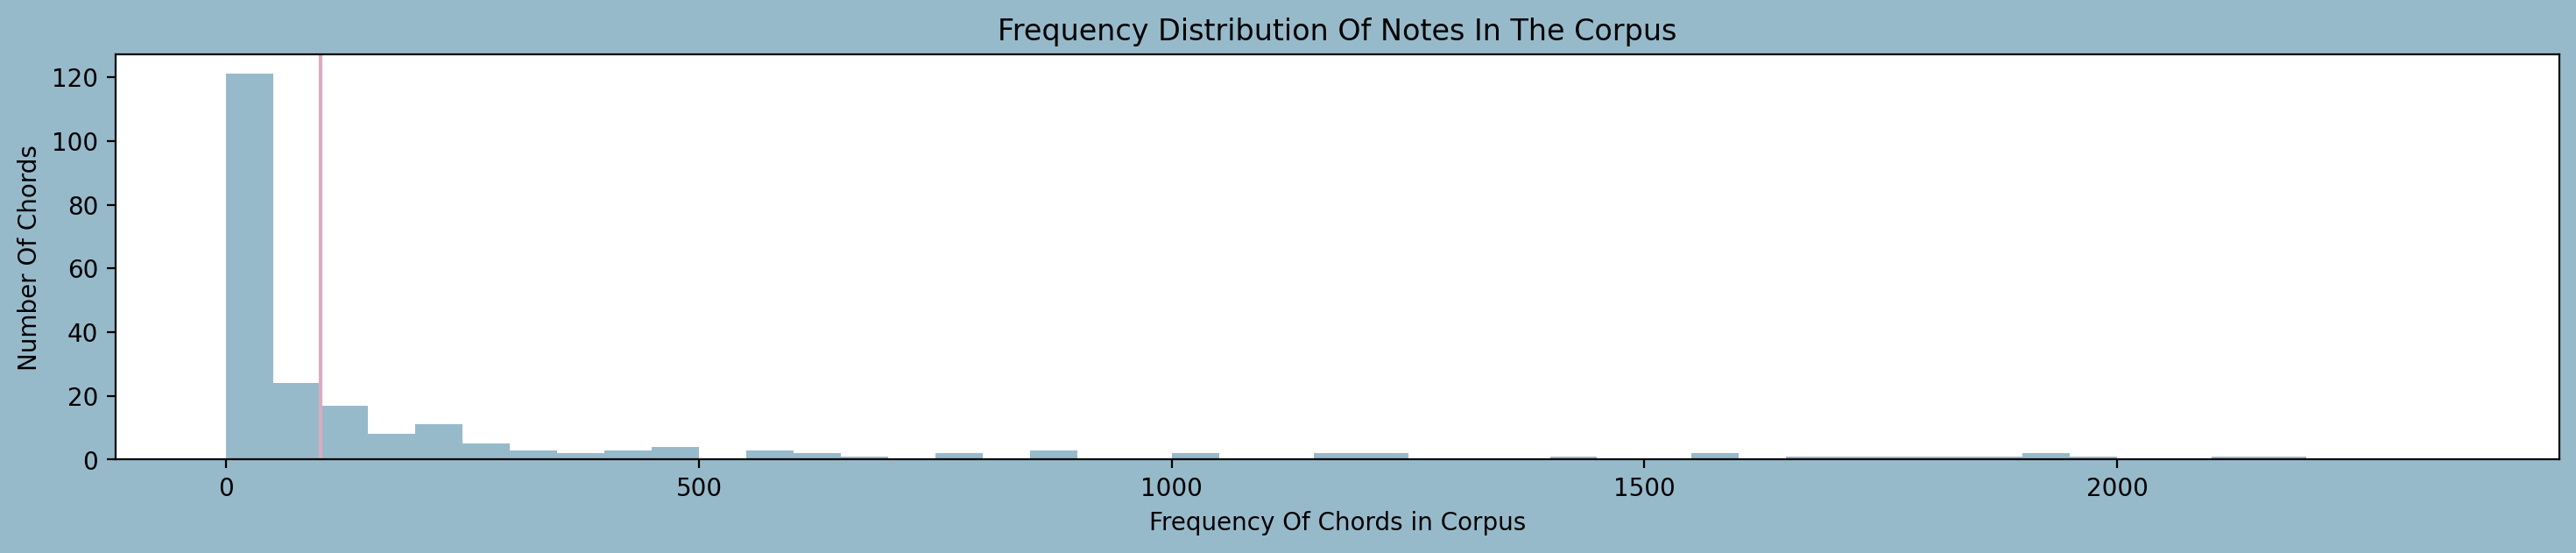

In [91]:
#Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()


# Data Training

In [92]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 55802
Number of unique characters: 229


In [93]:
#Encoding and Splitting the Corpus as Labels and Targets

#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 55762


In [95]:
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets) 

In [113]:
# Splitting Train and Seed datasets

#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=1)

# MODEL BUILDING

In [114]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)
#Model's Summary               
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 229)               58853     
                                                                 
Total params: 1,964,773
Trainable params: 1,964,773
No

In [127]:
#Generating the Melody

#A function to obtain the generated music

def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(1,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(100)
print(Melody)

<music21.stream.Stream 0x285b17bc670>


In [128]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')
#to play audio or corpus
IPython.display.Audio("../AI-model/Melody_Generated.mid", rate=  44100)

# Play the melody with PyGame

In [136]:
dataset_name = '../AI-model'
filename = 'Melody_generated'
file = "{}/{}.mid".format(dataset_name, filename)
original_score = converter.parse(file).chordify()
original_score.show()

SubConverterException: Cannot find a path to the 'mscore' file at c:\Users\DooFromash\Desktop\CODING\10.melody-generator-model\melody-generator-AI-App\AI-model\C:\Program Files\MuseScore 3\MuseScore.exe -- download MuseScore

In [129]:

import pygame

def play_music(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print ("Music file %s loaded!" % music_file)
    except pygame.error:
        print ("File %s not found! (%s)") % (music_file, pygame.get_error())
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)


# pick a midi music file you have ...
# (if not in working folder use full path)
music_file = "Melody_Generated.mid"

freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

try:
    play_music(music_file)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
    raise SystemExit 

Music file Melody_Generated.mid loaded!


AttributeError: 'tuple' object has no attribute 'tb_frame'